In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_original_data():
    return pd.read_excel("Data/Data_MidTerm_Project_Real_State_Regression.xls" )

In [3]:
def clean_data(df):
    df=df.dropna()
    ## droping columns
    df=df.drop(columns=['id','view','lat','long','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'])
    ## removing duplicates
    df=df.drop_duplicates()
    #date changed to dd/mm/year format
    df['date'] = df['date'].dt.strftime('%Y')
    #changing price values to currency format
    df['price'] = df['price'].apply(lambda x: "{:.2f}".format((x/1000)))
    df['price'] = df['price'].astype(float)
    return df

In [4]:
re_df=load_original_data()
re_df=clean_data(re_df)

In [5]:
re_df.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'yr_renovated',
       'zipcode', 'price'],
      dtype='object')

In [6]:
re_df

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode,price
0,2014,3,1.00,1180,5650,1.0,0,3,7,1955,0,98178,221.9
1,2014,3,2.25,2570,7242,2.0,0,3,7,1951,1991,98125,538.0
2,2015,2,1.00,770,10000,1.0,0,3,6,1933,0,98028,180.0
3,2014,4,3.00,1960,5000,1.0,0,5,7,1965,0,98136,604.0
4,2015,3,2.00,1680,8080,1.0,0,3,8,1987,0,98074,510.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014,3,2.50,1530,1131,3.0,0,3,8,2009,0,98103,360.0
21593,2015,4,2.50,2310,5813,2.0,0,3,8,2014,0,98146,400.0
21594,2014,2,0.75,1020,1350,2.0,0,3,7,2009,0,98144,402.1
21595,2015,3,2.50,1600,2388,2.0,0,3,8,2004,0,98027,400.0


### Plotting

Plot the distribution of price vs. number of bedrooms, price vs. number of bathrooms, price vs. condition, price vs. floors, price vs. grade, price vs. view, and price vs. waterfront.

State your observation for each one of those graphs. 
Do you see any trends in prices vs the rest of those variables individually? This can also be used for EDA to identify some data cleaning operations that you might need to perform further.

In [7]:
re_df[['bedrooms','bathrooms','floors','waterfront','condition','grade','yr_built','yr_renovated','zipcode']] = re_df[['bedrooms','bathrooms','floors','waterfront','condition','grade','yr_built','yr_renovated','zipcode']].astype(str)
# converting categorical columns

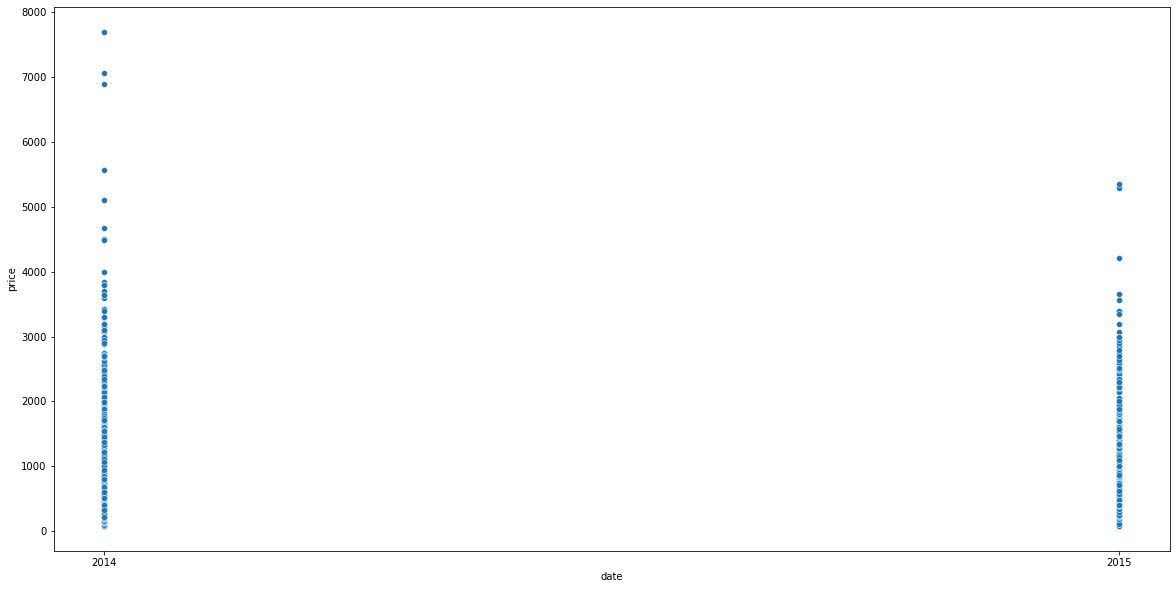

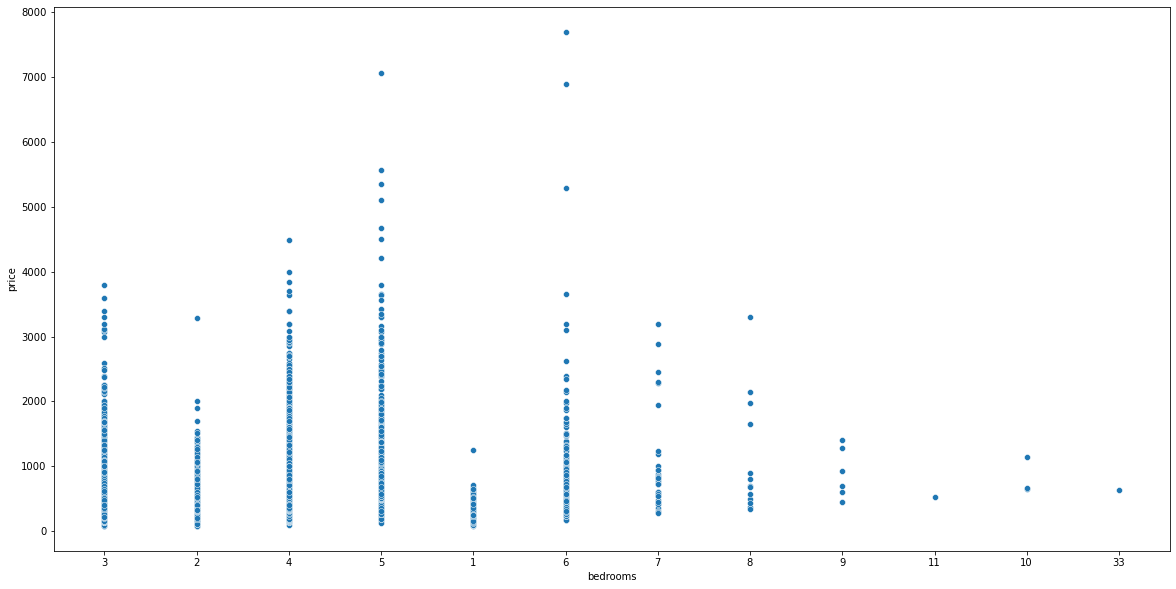

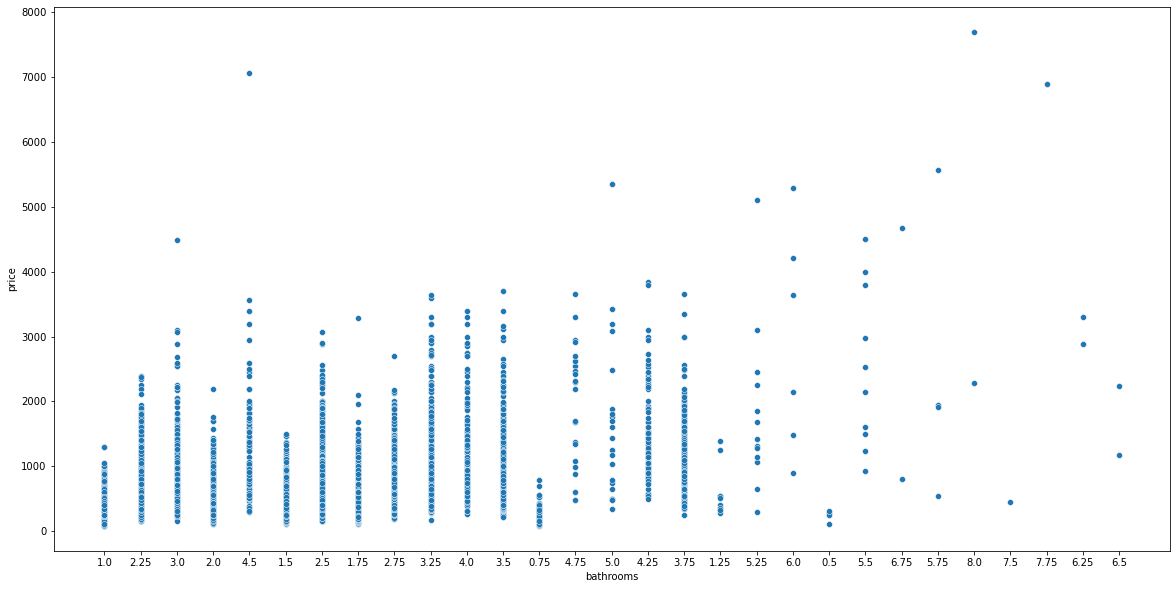

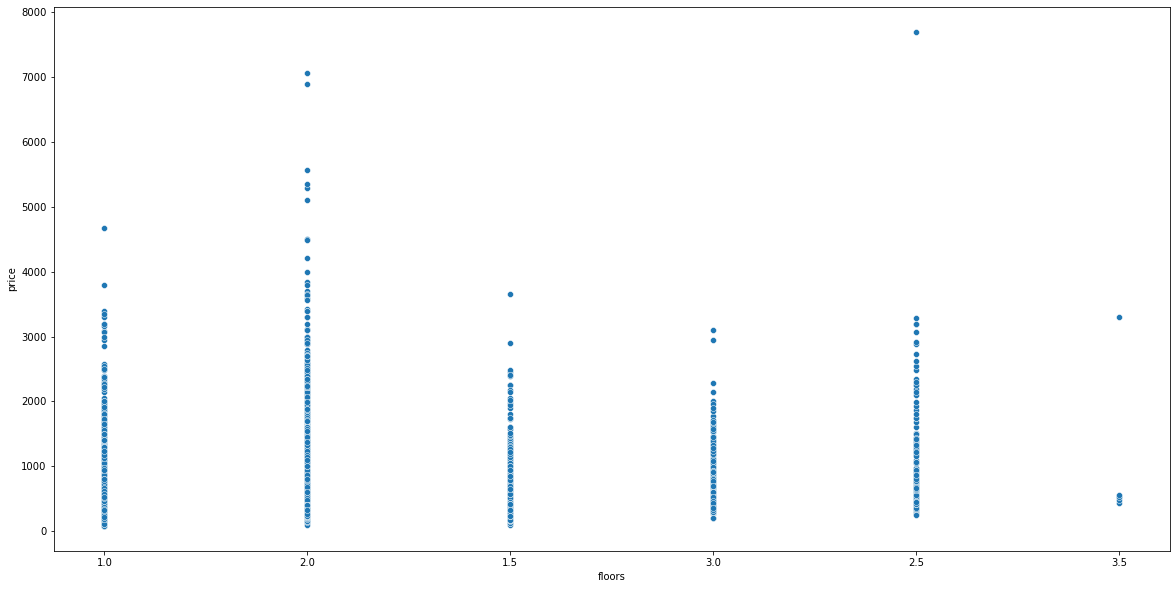

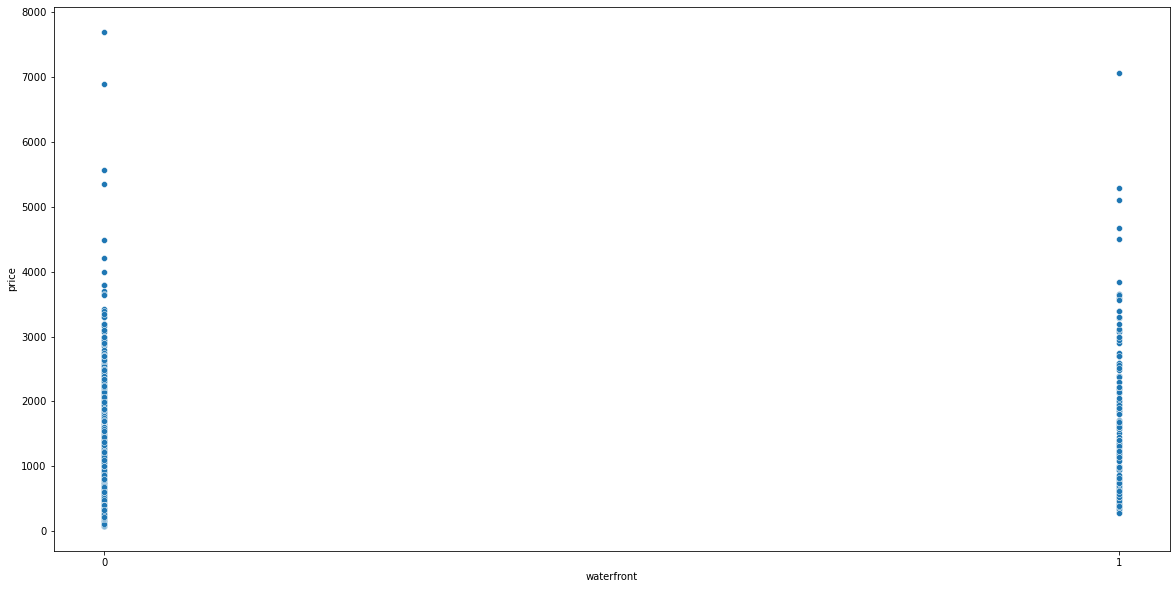

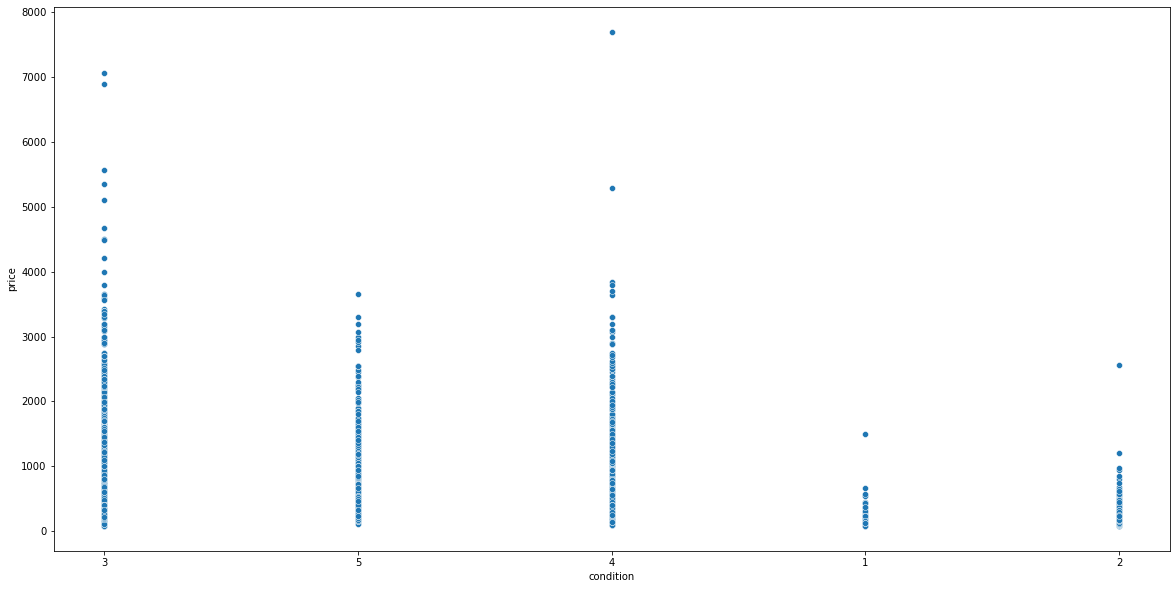

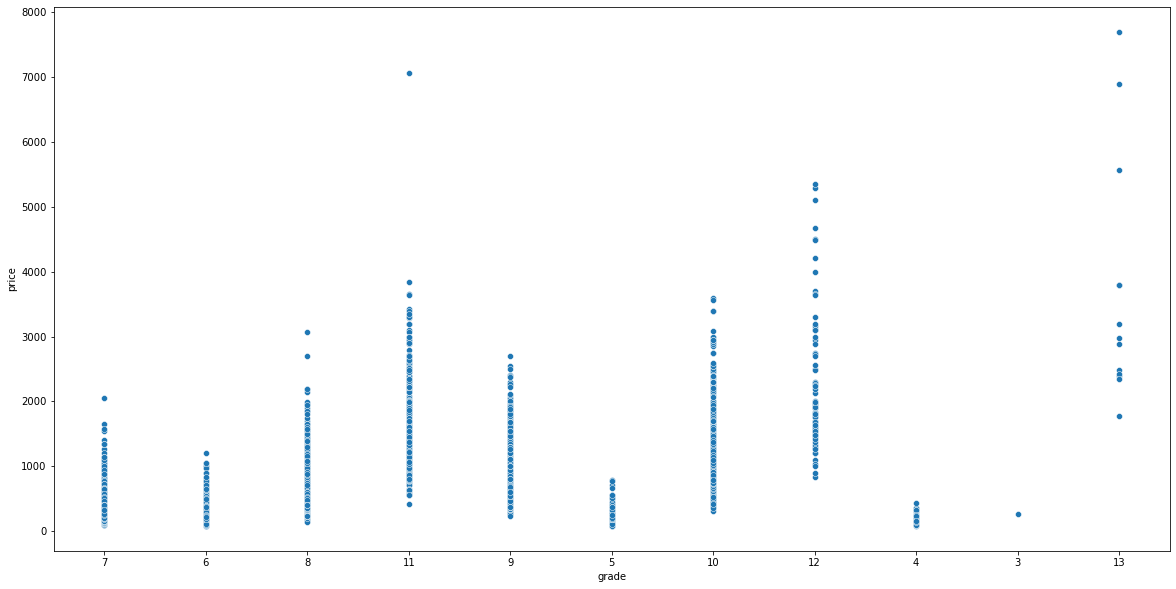

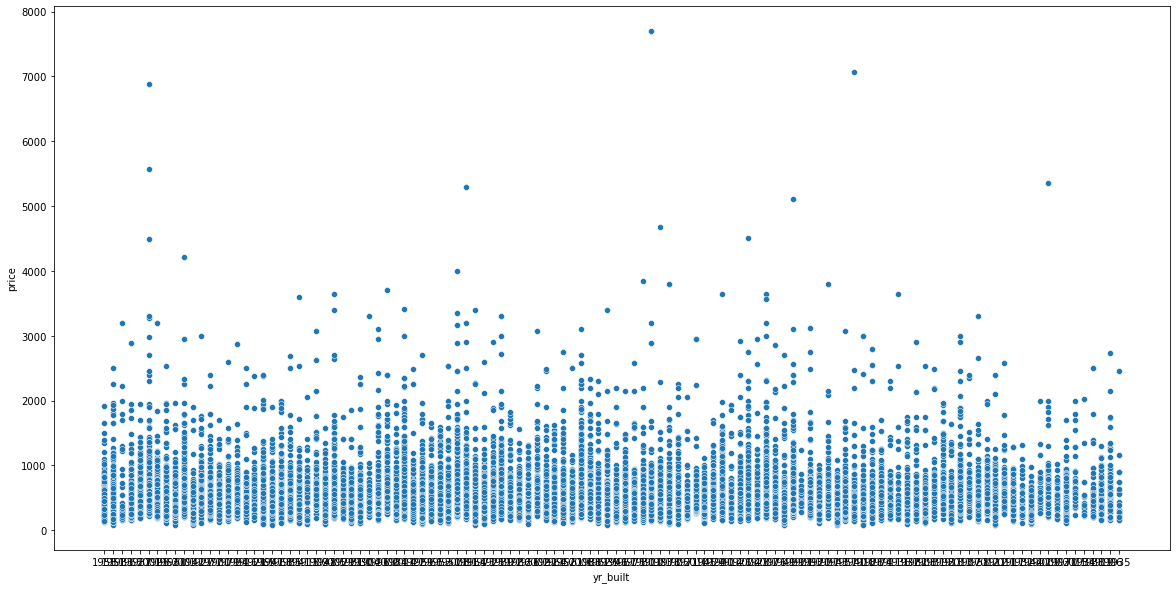

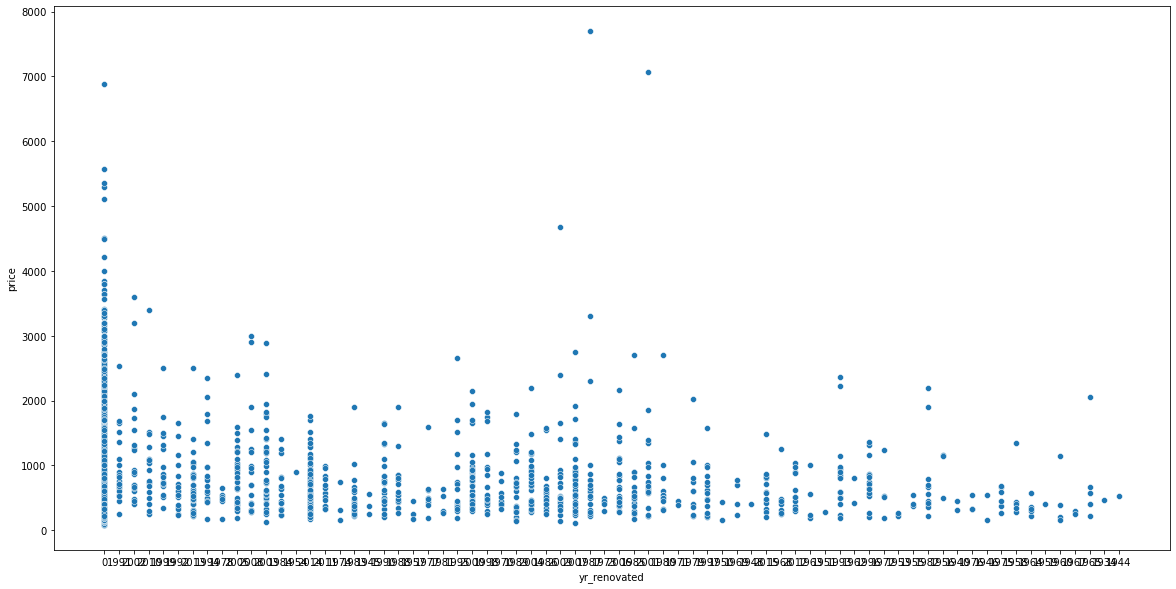

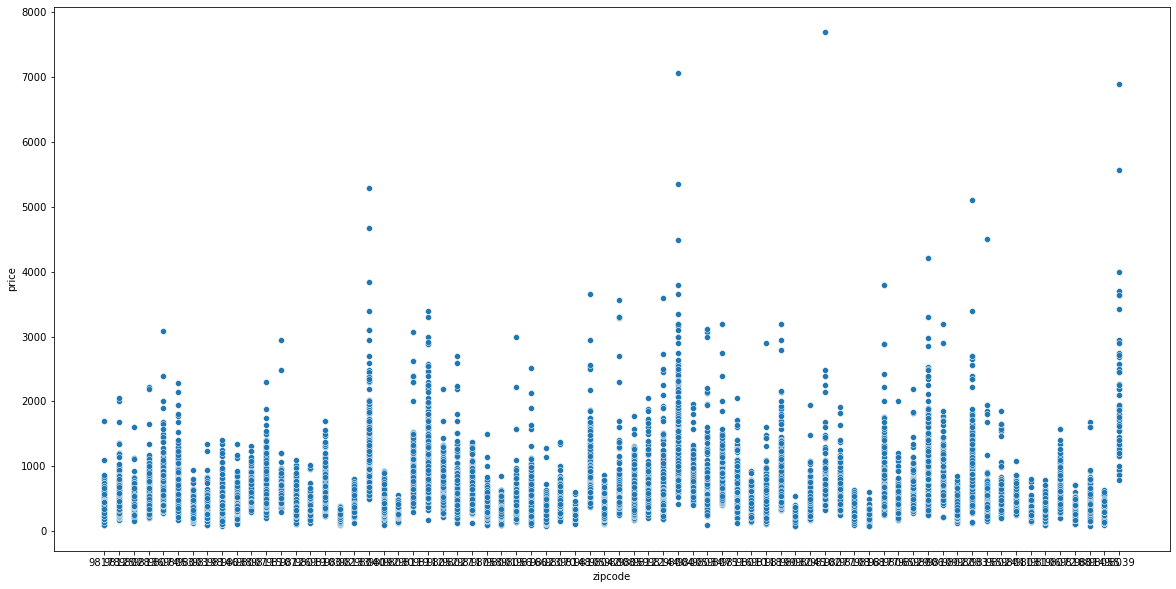

In [8]:
for c in re_df.select_dtypes(object):
    plt.figure(figsize=(20,10))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

In [9]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          21597 non-null  object 
 1   bedrooms      21597 non-null  object 
 2   bathrooms     21597 non-null  object 
 3   sqft_living   21597 non-null  int64  
 4   sqft_lot      21597 non-null  int64  
 5   floors        21597 non-null  object 
 6   waterfront    21597 non-null  object 
 7   condition     21597 non-null  object 
 8   grade         21597 non-null  object 
 9   yr_built      21597 non-null  object 
 10  yr_renovated  21597 non-null  object 
 11  zipcode       21597 non-null  object 
 12  price         21597 non-null  float64
dtypes: float64(1), int64(2), object(10)
memory usage: 2.3+ MB


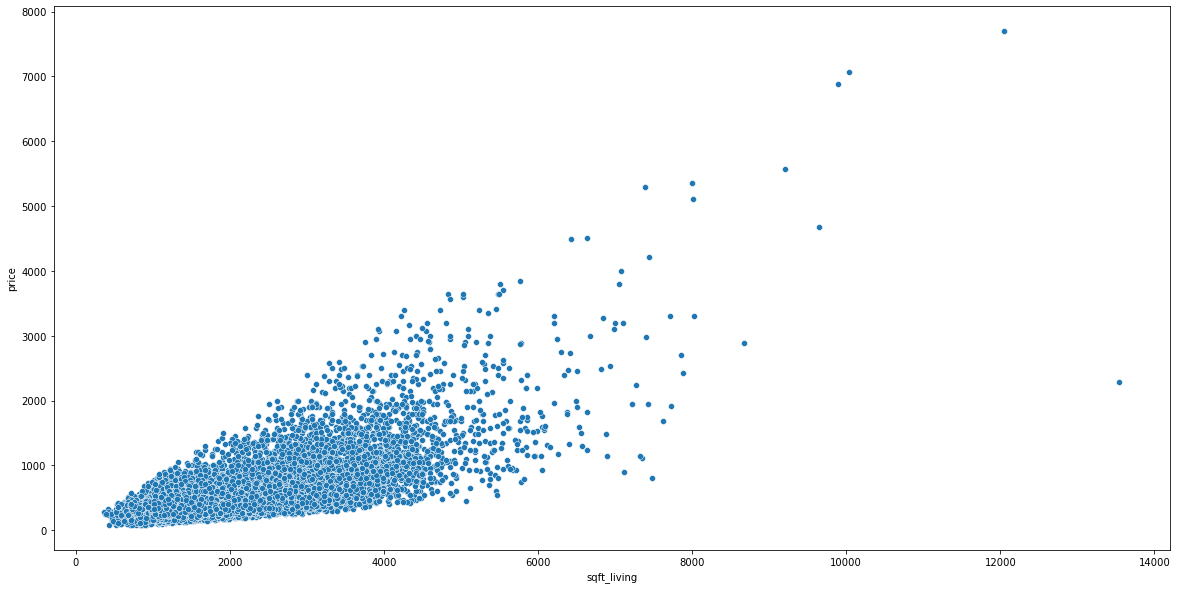

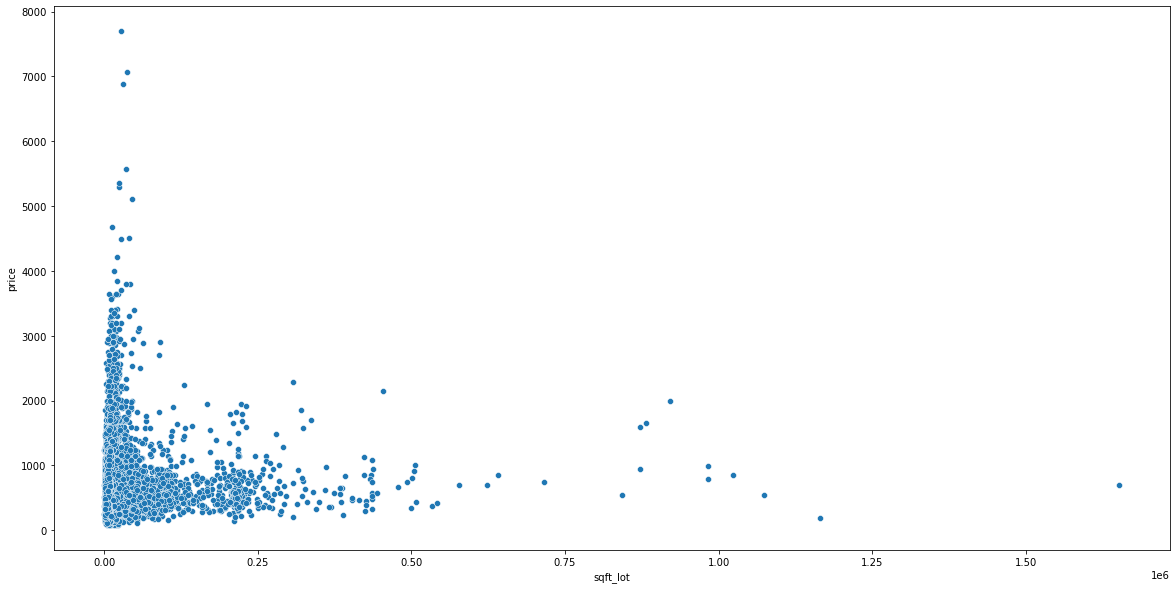

In [10]:
for c in re_df.select_dtypes(int):
    plt.figure(figsize=(20,10))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

# removing outliers

In [11]:
#sns.boxplot(re_df.sqft_living)

In [12]:
#sns.boxplot(re_df.sqft_lot)

Q1 = re_df.sqft_living.quantile(0.25)
Q3 = re_df.sqft_living.quantile(0.75)
IQR = Q3 - Q1
filter = (re_df['sqft_living'] >= Q1 - 1.5 * IQR) & (re_df['sqft_living'] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]

In [13]:
Q1 = re_df.sqft_lot.quantile(0.25)
Q3 = re_df.sqft_lot.quantile(0.75)
IQR = Q3 - Q1
filter = (re_df['sqft_lot'] >= Q1 - 1.5 * IQR) & (re_df['sqft_lot'] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]

In [14]:
#re_df.sqft_living.hist()

In [15]:
#re_df.sqft_lot.hist()

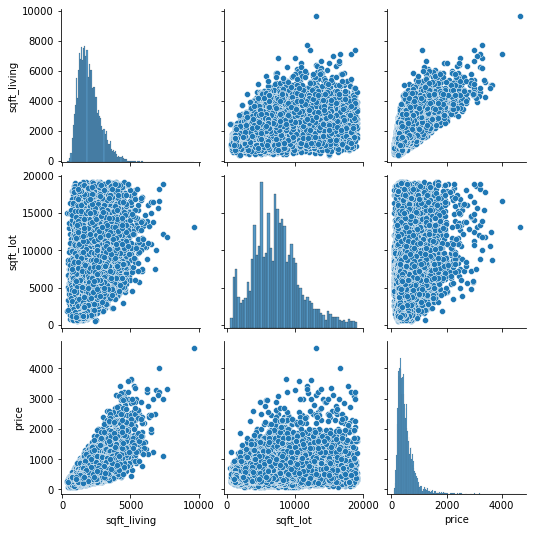

In [16]:
sns.pairplot(re_df)
plt.show()

<AxesSubplot:ylabel='Count'>

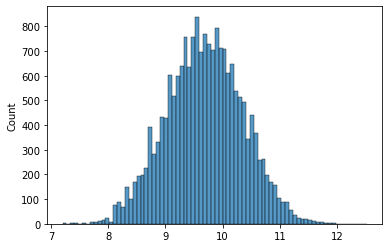

In [17]:
#data transformation
sqft_living_transformed,lam=boxcox(re_df['sqft_living'])
sns.histplot(sqft_living_transformed)

<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

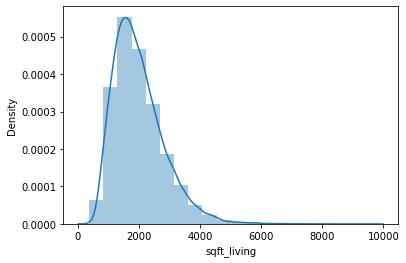

In [18]:
sns.distplot((re_df['sqft_living']), bins=20)

<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

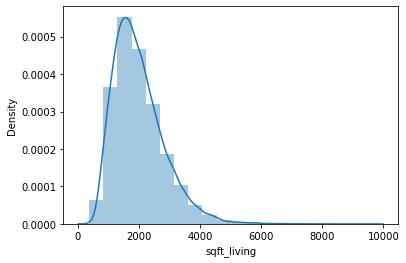

In [19]:
sns.distplot((re_df['sqft_living']), bins=20)

In [20]:
#checking correlation
numericals_features=re_df._get_numeric_data()
correlations = numericals_features.corr()
correlations

,sqft_living,sqft_lot,price
sqft_living,1.000000,0.271805,0.680838
sqft_lot,0.271805,1.000000,0.120187
price,0.680838,0.120187,1.000000


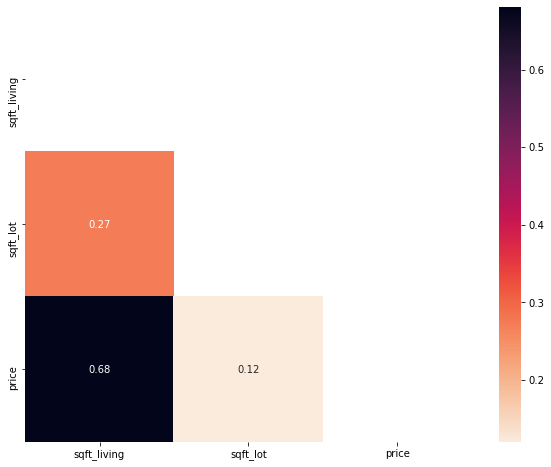

In [21]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(numericals_features.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(numericals_features.corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

In [22]:
#XY Split
x=re_df.drop('price', axis=1)
y=re_df.price

In [23]:
x

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode
0,2014,3,1.0,1180,5650,1.0,0,3,7,1955,0,98178
1,2014,3,2.25,2570,7242,2.0,0,3,7,1951,1991,98125
2,2015,2,1.0,770,10000,1.0,0,3,6,1933,0,98028
3,2014,4,3.0,1960,5000,1.0,0,5,7,1965,0,98136
4,2015,3,2.0,1680,8080,1.0,0,3,8,1987,0,98074
...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014,3,2.5,1530,1131,3.0,0,3,8,2009,0,98103
21593,2015,4,2.5,2310,5813,2.0,0,3,8,2014,0,98146
21594,2014,2,0.75,1020,1350,2.0,0,3,7,2009,0,98144
21595,2015,3,2.5,1600,2388,2.0,0,3,8,2004,0,98027


In [24]:
numericals_features =x._get_numeric_data()
# numericals =data.select_dtypes(np.number)
numericals_features

,sqft_living,sqft_lot
0,1180,5650
1,2570,7242
2,770,10000
3,1960,5000
4,1680,8080
...,...,...
21592,1530,1131
21593,2310,5813
21594,1020,1350
21595,1600,2388


In [25]:
numericals_features.describe()

,sqft_living,sqft_lot
count,19178.000000,19178.000000
mean,1992.711649,7385.103035
std,830.602049,3623.089457
min,370.000000,520.000000
25%,1390.000000,4905.500000
50%,1848.500000,7200.000000
75%,2440.000000,9436.750000
max,9640.000000,19141.000000


In [26]:
#Get Categorical data

categoricals_features = x.select_dtypes(object)
categoricals_features

,date,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode
0,2014,3,1.0,1.0,0,3,7,1955,0,98178
1,2014,3,2.25,2.0,0,3,7,1951,1991,98125
2,2015,2,1.0,1.0,0,3,6,1933,0,98028
3,2014,4,3.0,1.0,0,5,7,1965,0,98136
4,2015,3,2.0,1.0,0,3,8,1987,0,98074
...,...,...,...,...,...,...,...,...,...,...
21592,2014,3,2.5,3.0,0,3,8,2009,0,98103
21593,2015,4,2.5,2.0,0,3,8,2014,0,98146
21594,2014,2,0.75,2.0,0,3,7,2009,0,98144
21595,2015,3,2.5,2.0,0,3,8,2004,0,98027


## Categorical Variables Transformation

In [27]:
# get dummies pandas
categoricals_features=pd.get_dummies(categoricals_features)
categoricals_features

,date_2014,date_2015,bedrooms_1,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_0,waterfront_1,condition_1,condition_2,condition_3,condition_4,condition_5,grade_10,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1900,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_0,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_980

In [28]:
all_features=pd.concat([numericals_features, categoricals_features], axis=1) # concat numerical and categorical transformations

### Train Test Split

In [29]:
x_train, x_test, y_train, y_test=train_test_split(all_features, y, test_size=.10)

In [30]:
x_train

,sqft_living,sqft_lot,date_2014,date_2015,bedrooms_1,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_0,waterfront_1,condition_1,condition_2,condition_3,condition_4,condition_5,grade_10,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1900,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_0,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipc

In [31]:
# Standardize
std_scaler=StandardScaler().fit(x_train) 

x_train_scaled=std_scaler.transform(x_train)

In [32]:
x_test_scaled=std_scaler.transform(x_test)

In [33]:
x_train_scaled[0]

array([ 1.21027056e+00, -3.72890834e-01,  6.93018357e-01, -6.93018357e-01,
       -9.55022174e-02, -1.31849345e-02, -7.61188443e-03, -3.95732106e-01,
       -9.22678388e-01, -7.61188443e-03,  1.49568020e+00, -2.79180128e-01,
       -1.08820729e-01, -3.95823376e-02, -2.52530816e-02, -1.70226637e-02,
       -1.52250921e-02, -5.28086360e-02, -4.84012122e-01, -2.15340278e-02,
       -2.74571317e-01, -4.05470918e-01, -3.17656619e-01, -3.22606128e-01,
        1.74607902e+00, -2.34409346e-01, -1.86306600e-01, -1.55402712e-01,
       -1.80911617e-01, -8.18992973e-02, -7.36027889e-02, -5.65397659e-02,
       -6.28913989e-02, -2.74545857e-02, -2.52530816e-02, -2.15340278e-02,
       -1.70226637e-02, -7.61188443e-03, -7.61188443e-03, -7.61188443e-03,
       -7.61188443e-03, -7.61188443e-03, -1.00301730e+00, -3.07155348e-01,
        1.29651719e+00, -8.50660204e-02, -1.80911617e-01, -2.01426547e-02,
        6.86662878e-02, -6.86662878e-02, -3.04607775e-02, -8.57542971e-02,
        7.29879140e-01, -

In [34]:
# Modelling without scaling

x_train_const= sm.add_constant(x_train) # adding a constant

model = sm.OLS(y_train, x_train_const).fit()
predictions_train = model.predict(x_train_const) 

x_test_const = sm.add_constant(x_test) # adding a constant
predictions_test = model.predict(x_test_const) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     291.9
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:53:00   Log-Likelihood:            -1.0838e+05
No. Observations:               17260   AIC:                         2.174e+05
Df Residuals:                   16948   BIC:                         2.198e+05
Df Model:                         311                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               315.0311     11.89

In [35]:
model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[1:].index.tolist()

['sqft_living',
 'sqft_lot',
 'date_2014',
 'date_2015',
 'bedrooms_1',
 'bedrooms_10',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bathrooms_0.75',
 'bathrooms_1.0',
 'bathrooms_1.25',
 'bathrooms_1.5',
 'bathrooms_1.75',
 'bathrooms_2.0',
 'bathrooms_2.25',
 'bathrooms_2.5',
 'bathrooms_2.75',
 'bathrooms_3.0',
 'bathrooms_3.25',
 'bathrooms_3.5',
 'bathrooms_4.25',
 'bathrooms_4.75',
 'bathrooms_5.0',
 'bathrooms_5.5',
 'bathrooms_6.0',
 'bathrooms_6.5',
 'bathrooms_6.75',
 'bathrooms_7.5',
 'floors_1.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.5',
 'waterfront_0',
 'waterfront_1',
 'condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'yr_built_1900',
 'yr_built_1901',
 'yr_built_1905',
 'yr_built_1907',
 'yr_built_1910',
 'yr_built_1911',
 'yr_built_1912',
 'yr_built_1913',
 'yr_built_1916',
 'yr_bui

In [36]:
significant_features=all_features[model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[1:].index.tolist()]

In [37]:
#with scaling

x_train.columns

Index(['sqft_living', 'sqft_lot', 'date_2014', 'date_2015', 'bedrooms_1',
       'bedrooms_10', 'bedrooms_11', 'bedrooms_2', 'bedrooms_3', 'bedrooms_33',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=321)

In [38]:
x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant

model = sm.OLS(y_train, x_train_const_scaled).fit()
predictions_train = model.predict(x_train_const_scaled) 

x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant
predictions_test = model.predict(x_test_const_scaled) 
print_model = model.summary()
print(print_model)

ValueError: shapes (1918,321) and (322,) not aligned: 321 (dim 1) != 322 (dim 0)

In [39]:
model=LinearRegression()    # model
model.fit(x_train_scaled, y_train)   # model train

y_pred=model.predict(x_test_scaled)   # model prediction


y_pred_train=model.predict(x_train_scaled)

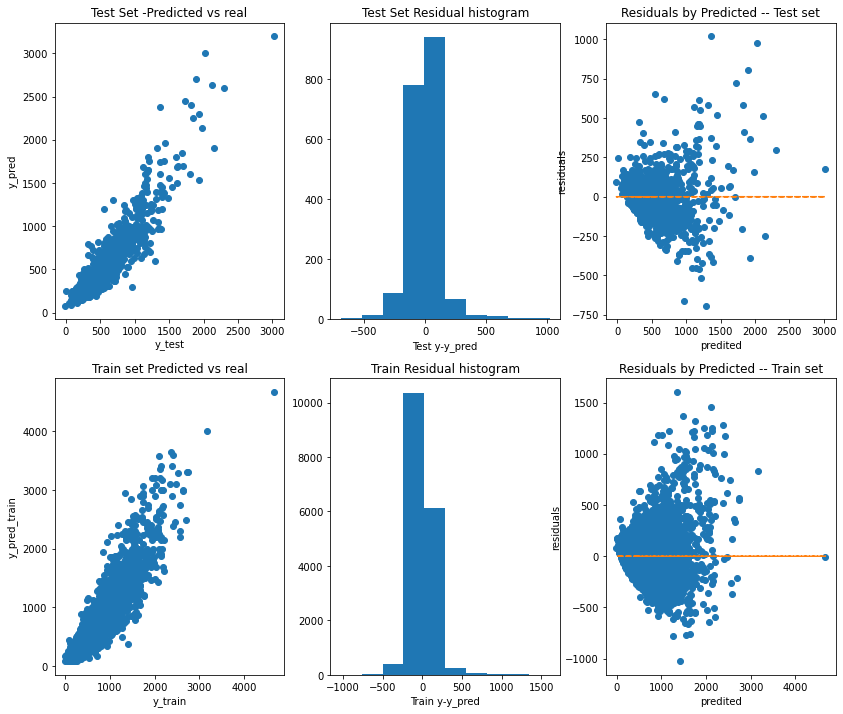

In [40]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(2,3,figsize=(14,12))
ax[0,0].plot(y_pred, y_test, 'o')
ax[0,0].set_xlabel("y_test")
ax[0,0].set_ylabel("y_pred")
ax[0,0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[0,1].hist(y_test - y_pred)
ax[0,1].set_xlabel("Test y-y_pred")
ax[0,1].set_title("Test Set Residual histogram")

ax[0,2].plot(y_pred,y_test - y_pred,"o")
ax[0,2].set_xlabel("predited")
ax[0,2].set_ylabel("residuals")
ax[0,2].set_title("Residuals by Predicted -- Test set")
ax[0,2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')


ax[1,0].plot(y_pred_train, y_train, 'o')
ax[1,0].set_xlabel("y_train")
ax[1,0].set_ylabel("y_pred_train")
ax[1,0].set_title("Train set Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1,1].hist(y_train - y_pred_train)
ax[1,1].set_xlabel("Train y-y_pred")
ax[1,1].set_title("Train Residual histogram")

ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
ax[1,2].set_xlabel("predited")
ax[1,2].set_ylabel("residuals")
ax[1,2].set_title("Residuals by Predicted -- Train set")
ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')

### Model Validation

In [41]:
#MSE
train_mse=mse(y_train,y_pred_train)
test_mse=mse(y_test,y_pred)

print ('train MSE: {} -- test MSE: {}'.format(train_mse, test_mse))

train MSE: 16649.90763594649 -- test MSE: 15088.296187593416


In [42]:
#RSME
print ('train RMSE: {} -- test RMSE: {}'.format(train_mse**.5, test_mse**.5))

train RMSE: 129.03452110170554 -- test RMSE: 122.83442590574279


In [43]:
#MAE

train_mae=mae(y_train,y_pred_train)
test_mae=mae(y_test,y_pred)

print ('train MAE: {} -- test MAE: {}'.format(train_mse, test_mse))

train MAE: 16649.90763594649 -- test MAE: 15088.296187593416


In [44]:
R2_train=r2_score(y_train,y_pred_train)
R2_test=r2_score(y_test,y_pred)

print (R2_train)
print(R2_test)

0.8426898339740247
0.8449139240798766


In [45]:
Adj_R2_train= 1 - (1-R2_train)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
Adj_R2_train

0.8397085750713008

In [46]:
Adj_R2_test= 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
Adj_R2_test

0.8137217997876713